In [1]:
'''Imports'''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
load_path = "./Cleaned Data/Historical/"

In [3]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

## Climate Analysis

In [4]:
#Import Precipitation
#Precip is in centimeters
precip = pd.read_csv(load_path + 'MEF_precipitation_daily.csv', 
                    parse_dates = ['DATE'])
precip['YEAR'] = precip.DATE.dt.year
precip['MONTH'] = precip.DATE.dt.month
precip['DOY'] = precip.DATE.dt.dayofyear
print(precip.head())

#Air temp is in Celcius
#Import Air Temperature
airTemp = pd.read_csv(load_path + 'MEF_airTemp_daily.csv', 
                    parse_dates = ['Date'])
airTemp['YEAR'] = airTemp.Date.dt.year
airTemp['MONTH'] = airTemp.Date.dt.month
airTemp['DOY'] = airTemp.Date.dt.dayofyear
airTemp = airTemp[airTemp.STATION == 'South'].reset_index(drop = True)
print(airTemp.head())

        DATE  NADP_PCP  South_PCP  North_PCP  NADP_Flag  South_Flag  \
0 1961-01-01       NaN       0.13        NaN        NaN         NaN   
1 1961-01-02       NaN       0.00        NaN        NaN         NaN   
2 1961-01-03       NaN       0.00        NaN        NaN         NaN   
3 1961-01-04       NaN       0.64        NaN        NaN         NaN   
4 1961-01-05       NaN       0.00        NaN        NaN         NaN   

   North_Flag  YEAR  MONTH  DOY  
0         NaN  1961      1    1  
1         NaN  1961      1    2  
2         NaN  1961      1    3  
3         NaN  1961      1    4  
4         NaN  1961      1    5  
        Date STATION  MAXC  MINC  FLAG  YEAR  MONTH  DOY
0 1961-01-01   South  -9.0 -29.0   NaN  1961      1    1
1 1961-01-02   South -15.0 -31.0   NaN  1961      1    2
2 1961-01-03   South -13.0 -36.0   NaN  1961      1    3
3 1961-01-04   South  -7.0 -18.0   NaN  1961      1    4
4 1961-01-05   South  -1.0 -14.0   NaN  1961      1    5


In [5]:
#Aggregate by month for plotting
precip_monthly = precip.groupby(['MONTH', 'YEAR'])['South_PCP'].sum().reset_index()
temp_monthly = airTemp.groupby(['MONTH', 'YEAR'])['MAXC', 'MINC'].mean().reset_index()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\3587095098.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_monthly = airTemp.groupby(['MONTH', 'YEAR'])['MAXC', 'MINC'].mean().reset_index()


In [6]:
precip_monthly.describe()

,MONTH,YEAR,South_PCP
count,757.000000,757.000000,757.000000
mean,6.492734,1992.042272,6.481149
std,3.457836,18.221399,4.744548
min,1.000000,1961.000000,0.030000
25%,3.000000,1976.000000,2.820000
50%,6.000000,1992.000000,5.280000
75%,9.000000,2008.000000,9.190000
max,12.000000,2024.000000,32.710000


Text(0, 18, 'Minimum daily\nMaximum daily')

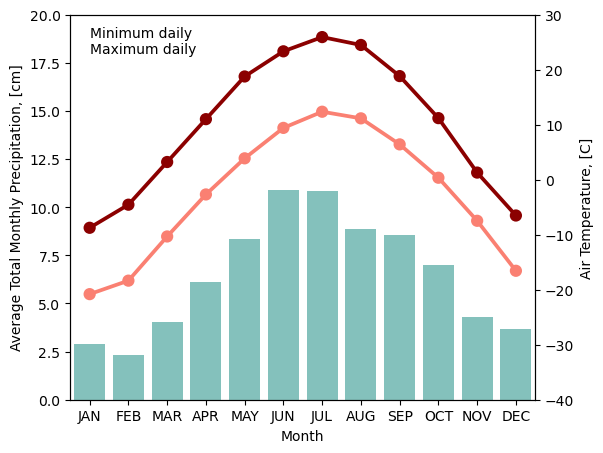

In [7]:
#Plot monthly averages
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

sns.barplot(x = precip_monthly.MONTH, y = precip_monthly.South_PCP,
            estimator = 'mean', 
            color = pal[2], 
            errorbar = None,
            ax = ax)
ax.set_ylim(0, 20)
ax.set_xlabel('Month')
ax.set_ylabel('Average Total Monthly Precipitation, [cm]')

ax2 = ax.twinx()

sns.pointplot(x = temp_monthly.MONTH - 1, y = temp_monthly.MAXC, 
            estimator = 'mean', 
            color = 'darkred',
            errorbar = None)
sns.pointplot(x = temp_monthly.MONTH - 1, y = temp_monthly.MINC, 
            estimator = 'mean', 
            color = 'salmon', 
            errorbar = None)
ax2.set_ylim(-40, 30)
ax2.set_ylabel('Air Temperature, [C]')

ax.set_xticklabels(labels = ('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
ax.text(0, 18, 'Minimum daily\nMaximum daily')


### Sort Snow Data by peak SWE value

In [8]:
snowHist = pd.read_csv(load_path + 'MEF_snowSWE_biweekly.csv', 
                parse_dates = ['Date'])

#Segment out S2 data
snowHist_S2 = snowHist[snowHist.Watershed == 'S2'].reset_index(drop = True)

#Group by snow course and find max annual SWE
snowHist_S2['Year'] = snowHist_S2.Date.dt.year
snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

snowHist_S2_grouped.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\559406229.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,SnowcourseID,Year,SnowDEPTH,SWE
0,S21,1962,55.0,12.0
1,S21,1963,50.0,9.0
2,S21,1964,43.0,8.0
3,S21,1965,67.0,17.0
4,S21,1966,60.0,19.0


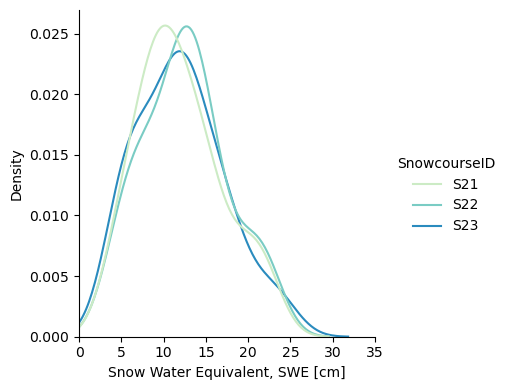

In [9]:
#S21 - South Upland, S22 - Bog, S23 - North Upland
g = sns.displot(snowHist_S2_grouped, x="SWE", hue="SnowcourseID", kind = 'kde', 
            height = 4, 
            palette = 'GnBu')
g.set(xlim = (0, 35))
g.set_axis_labels("Snow Water Equivalent, SWE [cm]", "Density")
plt.show()

In [10]:
#Group further by only year
snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

#Separate years into quantiles
snowHist_S2_grouped_all['Quants'] = pd.qcut(snowHist_S2_grouped_all.SWE, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
snowHist_S2_grouped_all.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\1823197670.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,Year,SnowDEPTH,SWE,Quants
0,1962,55.0,12.0,MedSno
1,1963,51.0,9.0,LoSno
2,1964,45.0,8.0,LoSno
3,1965,71.0,17.0,HighSno
4,1966,71.0,22.0,HighSno


Text(0, 0.5, 'Peak annual SWE, [cm]')

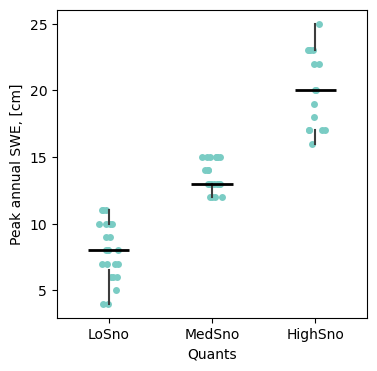

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.stripplot(data = snowHist_S2_grouped_all, x = 'Quants', y = 'SWE', 
              color = pal[2], zorder = 0)
sns.boxplot(data = snowHist_S2_grouped_all, x = 'Quants', y = 'SWE',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            width = 0.4, 
            ax = ax, zorder = 1)

ax.set_ylabel('Peak annual SWE, [cm]')

### Sort Snow Data by total snow inputs

In [12]:
#Import Grand Rapids snow data
gr_snow = pd.read_csv(load_path + 'GR_ForestryLab_snow_daily.csv', 
                    parse_dates = ['Date'], 
                    header = 1, 
                    names = ["Date","MaxT_F","MinT_F","Precip_in","Snowfall_in","SnowDepth_in"], 
                    na_values = ['T', 'M', 'S'], 
                    dtype = {'Precip_in': np.float64})

#limit to years of interest
gr_snow = gr_snow[(gr_snow.Date.dt.year > 1961) & (gr_snow.Date.dt.year < 2024)].reset_index(drop = True)

gr_snow

,Date,MaxT_F,MinT_F,Precip_in,Snowfall_in,SnowDepth_in
0,1962-01-01,24.0,5.0,0.02,0.3,10.0
1,1962-01-02,29.0,11.0,NaN,NaN,10.0
2,1962-01-03,37.0,23.0,0.00,0.0,7.0
3,1962-01-04,34.0,18.0,0.04,0.5,7.0
4,1962-01-05,21.0,-15.0,0.10,1.5,8.0
...,...,...,...,...,...,...
22640,2023-12-27,37.0,32.0,0.08,0.0,0.0
22641,2023-12-28,34.0,26.0,0.00,0.0,0.0
22642,2023-12-29,42.0,21.0,0.00,0.0,0.0
22643,2023-12-30,30.0,22.0,0.04,0.5,1.0


In [13]:
#Separate out the precipitation that is snow from the precipitation that is rain
#Snow is double counted in the snow and precip columns -- assume precip on days when there is also a snow value are SWE
gr_snow['Snowfall_SWE_in'] = np.where(gr_snow.Snowfall_in > 0, gr_snow.Precip_in, 0)

In [14]:
#Aggregate by year and find total inputs
gr_snow['Year'] = gr_snow.Date.dt.year

#groupby
gr_snow_annual = gr_snow.groupby(['Year'])['Snowfall_in', 'Precip_in', 'Snowfall_SWE_in'].sum().reset_index(drop = False)

gr_snow_annual.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\2448768633.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gr_snow_annual = gr_snow.groupby(['Year'])['Snowfall_in', 'Precip_in', 'Snowfall_SWE_in'].sum().reset_index(drop = False)


,Year,Snowfall_in,Precip_in,Snowfall_SWE_in
0,1962,46.5,25.51,3.54
1,1963,43.6,25.33,4.22
2,1964,48.1,30.39,3.59
3,1965,88.6,32.37,7.90
4,1966,67.7,26.77,8.41


In [15]:
#Bin by total annual snow inputs
gr_snow_annual['Input_Quants'] = pd.qcut(gr_snow_annual.Snowfall_in, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
gr_snow_annual.head()

,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,Input_Quants
0,1962,46.5,25.51,3.54,LoSno
1,1963,43.6,25.33,4.22,LoSno
2,1964,48.1,30.39,3.59,LoSno
3,1965,88.6,32.37,7.90,HighSno
4,1966,67.7,26.77,8.41,HighSno


### Sort Snow Data by snow fraction

In [16]:
#Calculate snowfall fraction
gr_snow_annual['SnowFraction'] = gr_snow_annual.Snowfall_SWE_in/gr_snow_annual.Precip_in

#Bin by total annual snow inputs
gr_snow_annual['Fraction_Quants'] = pd.qcut(gr_snow_annual.SnowFraction, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
gr_snow_annual.head()

,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,Input_Quants,SnowFraction,Fraction_Quants
0,1962,46.5,25.51,3.54,LoSno,0.138769,LoSno
1,1963,43.6,25.33,4.22,LoSno,0.166601,MedSno
2,1964,48.1,30.39,3.59,LoSno,0.118131,LoSno
3,1965,88.6,32.37,7.90,HighSno,0.244053,HighSno
4,1966,67.7,26.77,8.41,HighSno,0.314158,HighSno


### Plot binning sensitivity

In [17]:
#merge with original bins
binning_data = pd.merge(gr_snow_annual, snowHist_S2_grouped_all, on = ['Year'])
binning_data

,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,Input_Quants,SnowFraction,Fraction_Quants,SnowDEPTH,SWE,Quants
0,1962,46.5,25.51,3.54,LoSno,0.138769,LoSno,55.0,12.0,MedSno
1,1963,43.6,25.33,4.22,LoSno,0.166601,MedSno,51.0,9.0,LoSno
2,1964,48.1,30.39,3.59,LoSno,0.118131,LoSno,45.0,8.0,LoSno
3,1965,88.6,32.37,7.90,HighSno,0.244053,HighSno,71.0,17.0,HighSno
4,1966,67.7,26.77,8.41,HighSno,0.314158,HighSno,71.0,22.0,HighSno
...,...,...,...,...,...,...,...,...,...,...
56,2019,83.4,33.49,7.82,HighSno,0.233503,HighSno,74.0,15.0,MedSno
57,2020,61.0,31.49,5.14,MedSno,0.163226,LoSno,66.0,19.0,HighSno
58,2021,52.7,25.24,5.40,MedSno,0.213946,MedSno,25.0,7.0,LoSno
59,2022,76.1,33.40,9.43,HighSno,0.282335,HighSno,69.0,17.0,HighSno


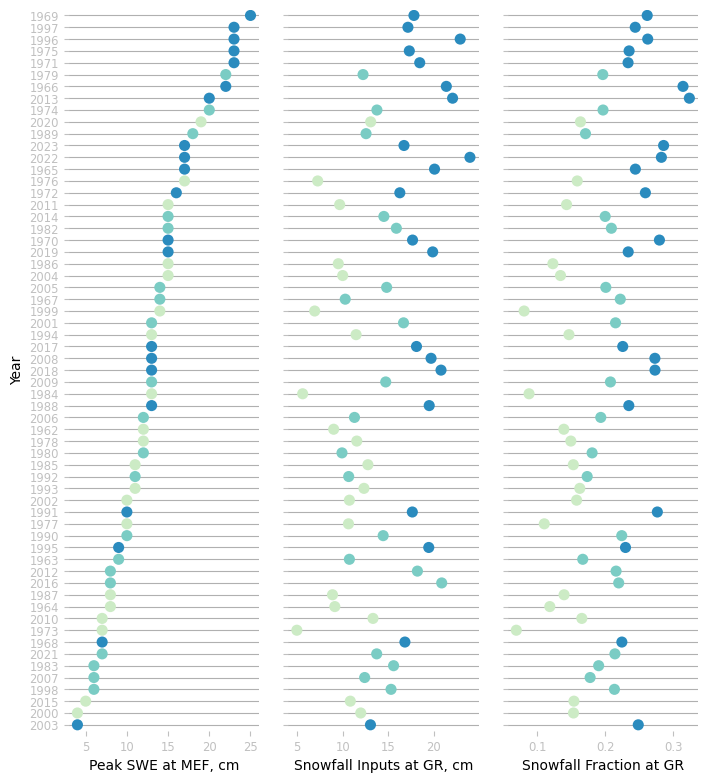

In [18]:
#Plot binning variation
#Cast years as string for plotting
binning_data['Year'] = [str(y) for y in binning_data.Year]

#Convert Snowfall to cm
binning_data['Snowfall_cm'] = 2.54*binning_data.Snowfall_SWE_in

# Make the PairGrid
g = sns.PairGrid(binning_data.sort_values('SWE', ascending = False),
                 x_vars = binning_data[['SWE', 'Snowfall_cm', 'SnowFraction']], y_vars = ["Year"],
                 height=8, aspect=.3, 
                 hue = 'Fraction_Quants', 
                 palette = 'GnBu')

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor = None)

# Use semantically meaningful titles for the columns
titles = ["Peak SWE at MEF, cm", "Snowfall Inputs at GR, cm", "Snowfall Fraction at GR"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set_xlabel(title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.tick_params(labelsize = 'small', labelcolor = 'silver', color = 'silver')
sns.despine(left=True, bottom=True)

plt.savefig('../Figures/HistoricalFigs/binning_comparison_fractionshading.pdf', bbox_inches = 'tight')

# Original SWE Binning

## Snow and Streamflow

In [19]:
streamHist = pd.read_csv(load_path + 'S2_Breakpoint_streamflow.csv', 
                parse_dates = ['DateTime'])

#groupby date and average across timestamps
#streamflow interval is total streamflow over the timestamp in mm
streamHist['Year'] = streamHist.DateTime.dt.year
streamHist['Month'] = streamHist.DateTime.dt.month
streamHist['DOY'] = streamHist.DateTime.dt.dayofyear
streamHist_dailyflows = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'Month'].mean().reset_index(drop = False)
streamHist_dailyInterval = streamHist.groupby(['DOY', 'Year'])['q.interval'].sum().reset_index(drop = False)
streamHist_daily = pd.merge(streamHist_dailyInterval, streamHist_dailyflows, on = ['DOY', 'Year'])

streamHist_daily.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\1737651431.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  streamHist_dailyflows = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'Month'].mean().reset_index(drop = False)


,DOY,Year,q.interval,Stage.ft,Q.cfs,q.mmh,Month
0,1,1963,0.00000,0.000,0.00000,0.00000,1.0
1,1,1964,0.00000,0.000,0.00000,0.00000,1.0
2,1,1965,0.00000,0.000,0.00000,0.00000,1.0
3,1,1966,0.00764,0.051,0.00303,0.00318,1.0
4,1,1967,0.00000,0.000,0.00000,0.00000,1.0


In [20]:
streamSnow = pd.merge(streamHist_daily, snowHist_S2_grouped_all, on = ['Year'], how = 'outer')
streamSnow.head()

,DOY,Year,q.interval,Stage.ft,Q.cfs,q.mmh,Month,SnowDEPTH,SWE,Quants
0,1.0,1963,0.0,0.0,0.0,0.0,1.0,51.0,9.0,LoSno
1,2.0,1963,0.0,0.0,0.0,0.0,1.0,51.0,9.0,LoSno
2,3.0,1963,0.0,0.0,0.0,0.0,1.0,51.0,9.0,LoSno
3,4.0,1963,0.0,0.0,0.0,0.0,1.0,51.0,9.0,LoSno
4,5.0,1963,0.0,0.0,0.0,0.0,1.0,51.0,9.0,LoSno


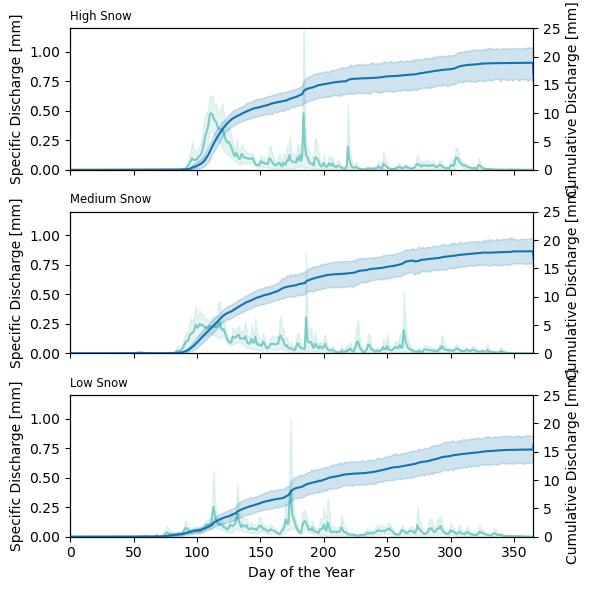

In [21]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (6, 6), 
                        sharex = True, 
                        sharey = True, 
                        layout = 'tight')

#High snow
hi = streamSnow[streamSnow.Quants == 'HighSno'].reset_index(drop = True)
hi['q_cumsum'] = hi.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = hi, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax1)
ax11 = ax1.twinx()
sns.lineplot(data = hi, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax11)
ax11.set_title('High Snow', loc = 'left', fontsize = 'small')
#Med snow
me = streamSnow[streamSnow.Quants == 'MedSno'].reset_index(drop = True)
me['q_cumsum'] = me.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = me, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax2)
ax22 = ax2.twinx()
sns.lineplot(data = me, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax22)
ax22.set_title('Medium Snow', loc = 'left', fontsize = 'small')

#Low snow
lo = streamSnow[streamSnow.Quants == 'LoSno'].reset_index(drop = True)
lo['q_cumsum'] = lo.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = lo, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax3)
ax33 = ax3.twinx()
sns.lineplot(data = lo, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax33)
ax33.set_title('Low Snow', loc = 'left', fontsize = 'small')

ax1.set_xlim(0, 365)
ax3.set_xlabel('Day of the Year')
ax1.set_ylim(0, 1.2)

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Specific Discharge [mm]')
    
for ax in [ax11, ax22, ax33]:
    ax.set_ylim(0, 25)
    ax.set_ylabel('Cumulative Discharge [mm]')


plt.savefig('../Figures/HistoricalFigs/streamflow_timeseries.pdf', bbox_inches = 'tight')

In [22]:
#Seasonal Streamflow Breakdown
streamSnow['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in streamSnow.Month]
streamSeasonal_sums = streamSnow.groupby(['Year', 'Quants', 'Season'])['q.interval'].sum().reset_index()
streamSeasonal_avgs = streamSnow.groupby(['Year', 'Quants', 'Season'])['SWE'].mean().reset_index()
streamSeasonal = pd.merge(streamSeasonal_sums, streamSeasonal_avgs, on = ['Year', 'Quants', 'Season'])
streamSeasonal.head()

,Year,Quants,Season,q.interval,SWE
0,1962,LoSno,Fall,0.00000,NaN
1,1962,LoSno,Spring,0.00000,NaN
2,1962,LoSno,Summer,0.00000,NaN
3,1962,MedSno,Fall,1.10805,12.0
4,1962,MedSno,Spring,13.06561,12.0


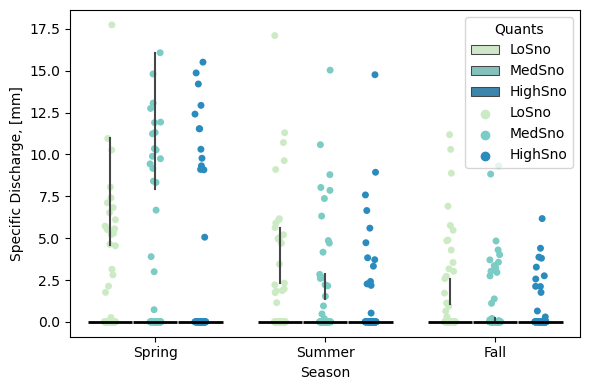

In [23]:
#Plot total streamflow in each season by snow year type
fig, ax = plt.subplots(1, 1, figsize = (6, 4),  
                       layout = 'tight')

streamSeasonal.Season = pd.Categorical(streamSeasonal.Season, 
                      categories = ["Spring","Summer","Fall"],
                      ordered = True)


sns.boxplot(data = streamSeasonal, x = 'Season', y = 'q.interval', hue = 'Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            fliersize = 0,
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = streamSeasonal, x = 'Season', y = 'q.interval', hue = 'Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)
ax.set_ylabel('Specific Discharge, [mm]')


plt.savefig('../Figures/HistoricalFigs/streamflow_boxplot.pdf', bbox_inches = 'tight')

In [24]:
#Statistical Analysis
LoSno_Spring = streamSeasonal[(streamSeasonal.Quants == 'LoSno') & (streamSeasonal.Season == 'Spring')].dropna(subset = ['q.interval'])
LoSno_Summer = streamSeasonal[(streamSeasonal.Quants == 'LoSno') & (streamSeasonal.Season == 'Summer')].dropna(subset = ['q.interval'])
LoSno_Fall = streamSeasonal[(streamSeasonal.Quants == 'LoSno') & (streamSeasonal.Season == 'Fall')].dropna(subset = ['q.interval'])

MedSno_Spring = streamSeasonal[(streamSeasonal.Quants == 'MedSno') & (streamSeasonal.Season == 'Spring')].dropna(subset = ['q.interval'])
MedSno_Summer = streamSeasonal[(streamSeasonal.Quants == 'MedSno') & (streamSeasonal.Season == 'Summer')].dropna(subset = ['q.interval'])
MedSno_Fall = streamSeasonal[(streamSeasonal.Quants == 'MedSno') & (streamSeasonal.Season == 'Fall')].dropna(subset = ['q.interval'])

HighSno_Spring = streamSeasonal[(streamSeasonal.Quants == 'HighSno') & (streamSeasonal.Season == 'Spring')].dropna(subset = ['q.interval'])
HighSno_Summer = streamSeasonal[(streamSeasonal.Quants == 'HighSno') & (streamSeasonal.Season == 'Summer')].dropna(subset = ['q.interval'])
HighSno_Fall = streamSeasonal[(streamSeasonal.Quants == 'HighSno') & (streamSeasonal.Season == 'Fall')].dropna(subset = ['q.interval'])

stream_ANOVA = scipy.stats.f_oneway(LoSno_Spring['q.interval'], LoSno_Summer['q.interval'], LoSno_Fall['q.interval'],
                                   MedSno_Spring['q.interval'], MedSno_Summer['q.interval'], MedSno_Fall['q.interval'], 
                                   HighSno_Spring['q.interval'], HighSno_Summer['q.interval'], HighSno_Fall['q.interval'])

print(stream_ANOVA)

stream_Tukey = scipy.stats.tukey_hsd(LoSno_Spring['q.interval'], LoSno_Summer['q.interval'], LoSno_Fall['q.interval'],
                                   MedSno_Spring['q.interval'], MedSno_Summer['q.interval'], MedSno_Fall['q.interval'], 
                                   HighSno_Spring['q.interval'], HighSno_Summer['q.interval'], HighSno_Fall['q.interval'])

print(stream_Tukey)

F_onewayResult(statistic=3.511134473197668, pvalue=0.0005694301919832562)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.163     1.000    -1.732     2.058
 (0 - 2)      0.816     0.919    -1.080     2.711
 (0 - 3)     -0.965     0.813    -2.860     0.930
 (0 - 4)      0.643     0.980    -1.253     2.538
 (0 - 5)      1.232     0.527    -0.663     3.127
 (0 - 6)     -0.202     1.000    -2.097     1.693
 (0 - 7)      1.075     0.705    -0.821     2.970
 (0 - 8)      1.603     0.175    -0.293     3.498
 (1 - 0)     -0.163     1.000    -2.058     1.732
 (1 - 2)      0.653     0.978    -1.242     2.548
 (1 - 3)     -1.128     0.647    -3.023     0.768
 (1 - 4)      0.480     0.997    -1.415     2.375
 (1 - 5)      1.069     0.711    -0.826     2.964
 (1 - 6)     -0.365     1.000    -2.260     1.531
 (1 - 7)      0.912     0.856    -0.984     2.807
 (1 - 8)      1.440     0.305    -0.455     3.335
 (2 - 0)

## Seasonal Soil Moisture Data

In [25]:
'''Load Data'''
soilMoist = pd.read_csv(load_path + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

In [26]:
soilMoist.head()

,DATE,LOCATION,d.15,d.46,d.76,d.107,d.137,d.168,d.198,d.229,d.259,d.290,d.320
0,1966-09-14,S1S,NaN,3.81,2.13,2.67,2.44,2.74,2.44,2.74,10.36,11.51,11.05
1,1966-09-14,S2W,NaN,3.05,2.97,2.97,2.74,2.90,3.51,3.81,3.12,1.45,2.90
2,1966-09-14,S3E,NaN,1.52,0.91,2.67,3.81,1.37,2.97,1.83,1.52,0.46,NaN
3,1966-09-14,S3W,NaN,1.37,0.91,2.51,4.11,4.27,3.20,4.88,3.43,6.25,5.79
4,1966-09-14,S4S,NaN,1.75,1.68,2.97,3.28,3.96,2.74,3.51,2.67,2.59,NaN


In [27]:
'''Data Cleaning'''
#Refine to S2 and S6 measurements
sites = ['S2E', 'S2S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)].reset_index(drop = True)

    #test if bulktemp is at least one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

soilMoist_melt['PAW'] = PAW

#Add days and snow quantiles
soilMoist_melt['YEAR'] = soilMoist_melt.DATE.dt.year
soilMoist_melt['MONTH'] = soilMoist_melt.DATE.dt.month
soilMoist_melt['DOY'] = soilMoist_melt.DATE.dt.dayofyear

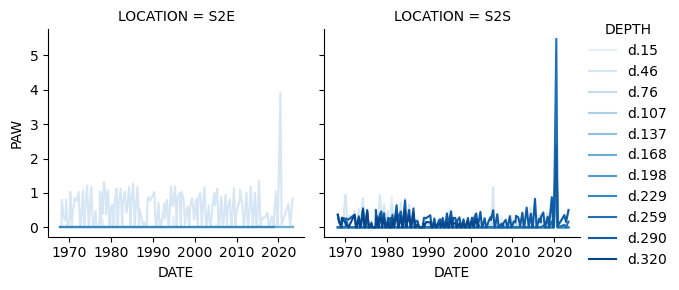

In [28]:
#Plot PAW timeseries
sns.relplot(data = soilMoist_melt, x = 'DATE', y = 'PAW',
            hue = 'DEPTH', palette = 'Blues',
            col = 'LOCATION', col_wrap = 2,
            kind = 'line', 
            height = 3)

In [29]:
#Sum down soil column
soilMoist_column = soilMoist_melt.groupby(['YEAR', 'MONTH', 'DATE', 'DOY', 'LOCATION'])['PAW'].sum().reset_index()
soilMoist_column.head() 

,YEAR,MONTH,DATE,DOY,LOCATION,PAW
0,1967,10,1967-10-31,304,S2E,0.000000
1,1968,3,1968-03-11,71,S2E,0.000000
2,1968,4,1968-04-30,121,S2E,0.839628
3,1968,4,1968-04-30,121,S2S,1.139704
4,1968,9,1968-09-12,256,S2E,0.616648


In [30]:
#Aggregate to seasonal scale (SWE in cm, q in mm, PAW in cm)
soilMoist_column['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in soilMoist_column.MONTH]
seasonalSoilM = soilMoist_column.groupby(['YEAR', 'Season', 'LOCATION'])['PAW'].mean().reset_index()
seasonalSoilM.head()

,YEAR,Season,LOCATION,PAW
0,1967,Fall,S2E,0.000000
1,1968,Fall,S2E,0.616648
2,1968,Fall,S2S,0.746912
3,1968,Spring,S2E,0.419814
4,1968,Spring,S2S,1.139704


In [31]:
#Merge with snow data
seasonalSoil = pd.merge(seasonalSoilM, streamSeasonal, left_on = ['YEAR', 'Season'], right_on = ['Year', 'Season'])

#Remove extra rows
seasonalSoil = seasonalSoil.dropna(subset = ['SWE'])

#Convert q to cm
seasonalSoil['q.interval'] = seasonalSoil['q.interval']/10

#Sort Season Data
seasonalSoil.Season = pd.Categorical(seasonalSoil.Season, 
                      categories = ["Spring","Summer","Fall"],
                      ordered = True)

seasonalSoil.head()


,YEAR,Season,LOCATION,PAW,Year,Quants,q.interval,SWE
1,1967,Fall,S2E,0.000000,1967,MedSno,0.000000,14.0
3,1968,Fall,S2E,0.616648,1968,LoSno,0.690824,7.0
6,1968,Fall,S2S,0.746912,1968,LoSno,0.690824,7.0
9,1968,Spring,S2E,0.419814,1968,LoSno,0.555887,7.0
12,1968,Spring,S2S,1.139704,1968,LoSno,0.555887,7.0


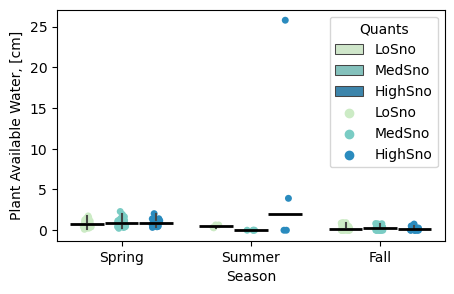

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

sns.boxplot(data = seasonalSoil, x = 'Season', y = 'PAW', hue = 'Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            fliersize = 0,
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = seasonalSoil, x = 'Season', y = 'PAW', hue = 'Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)

ax.set_ylabel('Plant Available Water, [cm]')
plt.savefig('../Figures/HistoricalFigs/PAW_boxplot.pdf', bbox_inches = 'tight')

#Both outliers here are from the summer of 2020 when all the point in all catchments show soil moisture values a magnitude larger than average

## 10 Minute Soil Moisture Data

In [33]:
soilMoist_10min = pd.read_csv(load_path + 'MEF_S2_soil_moisture_10min.csv', 
                              parse_dates = ['TIMESTAMP'])

soilMoist_10min['YEAR'] = soilMoist_10min.TIMESTAMP.dt.year
soilMoist_10min['MONTH'] = soilMoist_10min.TIMESTAMP.dt.month
soilMoist_10min['DOY'] = soilMoist_10min.TIMESTAMP.dt.dayofyear

#Only pull out full years
soilMoist_10min = soilMoist_10min[(soilMoist_10min.YEAR > 2008) & (soilMoist_10min.YEAR < 2023)]

#Aggregate to daily values
soilMoist_daily = soilMoist_10min.groupby(['YEAR', 'DOY', 'MONTH'])['S2S_UP_SH', 'S2S_UP_DP', 'S2S_MI_SH', 'S2S_MI_DP', 'S2S_LO_SH', 'S2S_LO_DP', 'S2N_UP_SH', 'S2N_UP_DP', 'S2N_MI_SH', 'S2N_MI_DP', 'S2N_LO_SH', 'S2N_LO_DP'].mean().reset_index()

soilMoist_daily.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_6688\3610185904.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soilMoist_daily = soilMoist_10min.groupby(['YEAR', 'DOY', 'MONTH'])['S2S_UP_SH', 'S2S_UP_DP', 'S2S_MI_SH', 'S2S_MI_DP', 'S2S_LO_SH', 'S2S_LO_DP', 'S2N_UP_SH', 'S2N_UP_DP', 'S2N_MI_SH', 'S2N_MI_DP', 'S2N_LO_SH', 'S2N_LO_DP'].mean().reset_index()


,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP
0,2009,1,1,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,1,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,3,1,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,4,1,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,5,1,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#Average across all columns and depths
soilMoist_daily['S2S'] = (soilMoist_daily.S2S_UP_SH + soilMoist_daily.S2S_UP_DP +
    soilMoist_daily.S2S_MI_SH + soilMoist_daily.S2S_MI_DP +
    soilMoist_daily.S2S_LO_SH + soilMoist_daily.S2S_LO_DP)/6

soilMoist_daily['S2N'] = (soilMoist_daily.S2N_UP_SH + soilMoist_daily.S2N_UP_DP +
    soilMoist_daily.S2N_MI_SH + soilMoist_daily.S2N_MI_DP +
    soilMoist_daily.S2N_LO_SH + soilMoist_daily.S2N_LO_DP)/6

In [35]:
#Merge with snow data
soilMoist_snow = pd.merge(soilMoist_daily, snowHist_S2_grouped_all[snowHist_S2_grouped_all.Year > 2007], left_on = 'YEAR', right_on = 'Year', how = 'outer')
soilMoist_snow = soilMoist_snow.drop('Year', axis = 1)
soilMoist_snow.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP,S2S,S2N,SnowDEPTH,SWE,Quants
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,0.226308,NaN,48.0,13.0,MedSno
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,0.225394,NaN,48.0,13.0,MedSno
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,0.225000,NaN,48.0,13.0,MedSno
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,0.225000,NaN,48.0,13.0,MedSno
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,NaN,NaN,NaN,NaN,NaN,0.225312,NaN,48.0,13.0,MedSno


In [36]:
all_water = pd.merge(soilMoist_snow, streamHist_daily[streamHist_daily.Year > 2007], left_on = ['YEAR', 'DOY'], right_on = ['Year', 'DOY'], 
                     how = 'outer')
all_water = all_water.drop('Year', axis = 1)
all_water.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,S2S,S2N,SnowDEPTH,SWE,Quants,q.interval,Stage.ft,Q.cfs,q.mmh,Month
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,0.226308,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0,1.0
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,0.225394,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0,1.0
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,0.225000,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0,1.0
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,0.225000,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0,1.0
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,0.225312,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0,1.0


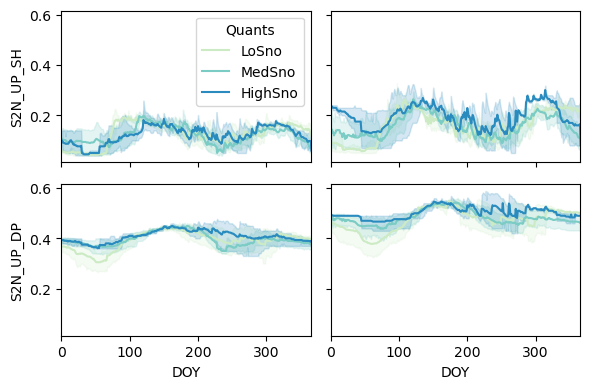

In [37]:
#Just soil moisture plot by area
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (6, 4), 
                                             layout = 'tight',
                                             sharey = True, 
                                             sharex = True)

sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2N_UP_SH", hue = "Quants", palette = 'GnBu',  ax = ax1)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2N_UP_DP", hue = "Quants", palette = 'GnBu', ax = ax3, legend = False)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2S_UP_SH", hue = "Quants", palette = 'GnBu', ax = ax2, legend = False)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2S_UP_DP", hue = "Quants", palette = 'GnBu', ax = ax4, legend = False)

ax1.set_xlim(0, 365)

plt.show()

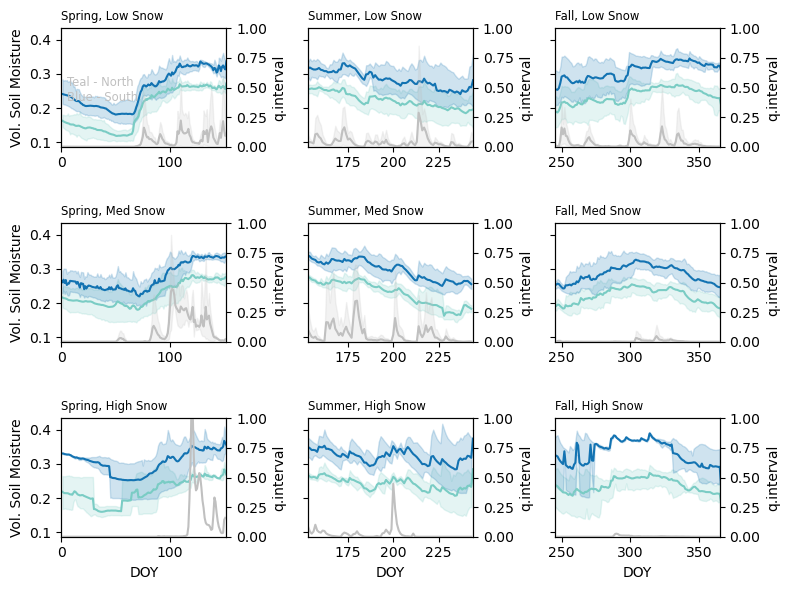

In [38]:
#Soil moisture and streamflow by snow year and season
def plot_SM_Q(ax_i, ax_j, soilM):
    #find season based on ax column index
    if(ax_i == 0): #spring
        soiltemp = soilM[soilM.MONTH < 6]
        axs[ax_j, ax_i].set_xlim(0, 152)
        axs[ax_j, ax_i].set_ylabel('Vol. Soil Moisture')
    elif(ax_i == 1): #summer
        soiltemp = soilM[(soilM.MONTH > 5) & (soilM.MONTH < 9)]
        axs[ax_j, ax_i].set_xlim(153, 244)
    else: #fall
        soiltemp = soilM[soilM.MONTH > 8]
        axs[ax_j, ax_i].set_xlim(245, 365)

    #find snow year based on ax row index
    if(ax_j == 0): #low snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'LoSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    elif(ax_j == 1): #med snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'MedSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    else: #high snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'HighSno']

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2N', ax = axs[ax_j, ax_i], color = pal[2])
    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2S', ax = axs[ax_j, ax_i], color = pal[4])

    ax2 = axs[ax_j, ax_i].twinx()

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'q.interval', 
                 color = 'silver', zorder = -2, 
                 ax = ax2)
    ax2.set_ylim(0, 1.0)

    season_labels = ['Spring', 'Summer', 'Fall']
    snow_labels = ['Low Snow', 'Med Snow', 'High Snow']

    axs[ax_j, ax_i].set_title(season_labels[ax_i] + ', ' + snow_labels[ax_j], loc = 'left', fontsize = 'small')

fig, axs = plt.subplots(3, 3, figsize = (8, 6), 
    sharey = True, 
    layout = 'tight')

for i in range(0, 3):
    for j in range(0, 3):
        plot_SM_Q(i, j, all_water)

axs[0, 0].text(5, 0.22, 'Teal - North\nBlue - South', color = 'silver', fontsize = 'small')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_Timeseries.pdf')
plt.show()


In [39]:
#Merge with soil moisture and snow data
all_water = pd.merge(all_water, precip[precip.YEAR > 2007], on = ['YEAR', 'DOY', 'MONTH'])
all_water['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in all_water.MONTH]
all_water.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,q.mmh,Month,DATE,NADP_PCP,South_PCP,North_PCP,NADP_Flag,South_Flag,North_Flag,Season
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,0.0,1.0,2009-01-01,NaN,0.10,0.15,NaN,NaN,NaN,Spring
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,0.0,1.0,2009-01-02,NaN,0.00,0.00,NaN,NaN,NaN,Spring
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,0.0,1.0,2009-01-03,NaN,1.70,1.78,NaN,NaN,NaN,Spring
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,0.0,1.0,2009-01-04,NaN,0.08,0.05,NaN,NaN,NaN,Spring
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,0.0,1.0,2009-01-05,NaN,0.00,0.00,NaN,NaN,NaN,Spring


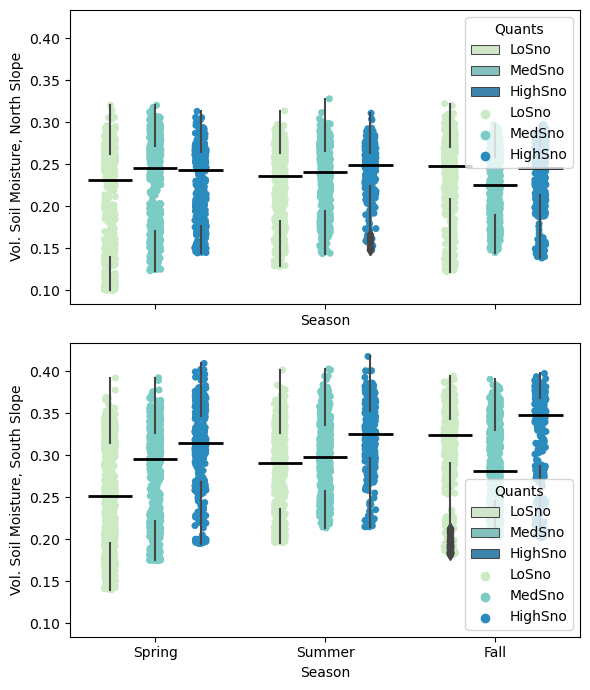

In [40]:
fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 7), 
                       sharex = True, 
                       sharey = True, 
                       layout = 'tight')

sns.boxplot(data = all_water, x = 'Season', y = 'S2N', hue = 'Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = all_water, x = 'Season', y = 'S2N', hue = 'Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)

ax.set_ylabel('Vol. Soil Moisture, North Slope')

sns.boxplot(data = all_water, x = 'Season', y = 'S2S', hue = 'Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax2, zorder = 1)
sns.stripplot(data = all_water, x = 'Season', y = 'S2S', hue = 'Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax2, zorder = 0)

ax2.set_ylabel('Vol. Soil Moisture, South Slope')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_boxplot.pdf')
plt.show()

In [41]:
#Statistical Analysis
LoSno_Spring = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S'])
LoSno_Summer = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S'])
LoSno_Fall = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S'])

MedSno_Spring = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S'])
MedSno_Summer = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S'])
MedSno_Fall = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S'])

HighSno_Spring = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S'])
HighSno_Summer = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S'])
HighSno_Fall = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S'])

soilM_ANOVA = scipy.stats.f_oneway(LoSno_Spring.S2S, LoSno_Summer.S2S, LoSno_Fall.S2S,
                                   MedSno_Spring.S2S, MedSno_Summer.S2S, MedSno_Fall.S2S, 
                                   HighSno_Spring.S2S, HighSno_Summer.S2S, HighSno_Fall.S2S)

print(soilM_ANOVA)

soilM_Tukey = scipy.stats.tukey_hsd(LoSno_Spring.S2S, LoSno_Summer.S2S, LoSno_Fall.S2S,
                                   MedSno_Spring.S2S, MedSno_Summer.S2S, MedSno_Fall.S2S, 
                                   HighSno_Spring.S2S, HighSno_Summer.S2S, HighSno_Fall.S2S)

print(soilM_Tukey)

F_onewayResult(statistic=93.74678470159996, pvalue=3.1964783432151786e-145)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.031     0.000    -0.041    -0.021
 (0 - 2)     -0.054     0.000    -0.064    -0.045
 (0 - 3)     -0.023     0.000    -0.032    -0.015
 (0 - 4)     -0.044     0.000    -0.053    -0.035
 (0 - 5)     -0.032     0.000    -0.040    -0.023
 (0 - 6)     -0.051     0.000    -0.061    -0.040
 (0 - 7)     -0.068     0.000    -0.080    -0.056
 (0 - 8)     -0.074     0.000    -0.086    -0.063
 (1 - 0)      0.031     0.000     0.021     0.041
 (1 - 2)     -0.023     0.000    -0.034    -0.013
 (1 - 3)      0.008     0.287    -0.002     0.017
 (1 - 4)     -0.013     0.005    -0.024    -0.002
 (1 - 5)     -0.001     1.000    -0.011     0.009
 (1 - 6)     -0.020     0.000    -0.031    -0.008
 (1 - 7)     -0.037     0.000    -0.050    -0.024
 (1 - 8)     -0.043     0.000    -0.056    -0.031
 (2 - 

# Snow Fraction Binning

## Snow and Streamflow

In [42]:
#Merge soil Moisture data with snow fraction bins
streamSnow_frac = pd.merge(streamHist_daily, gr_snow_annual[['Year', 'Input_Quants', 'SnowFraction', 'Fraction_Quants']],
                        on = ['Year'], how = 'outer')
streamSnow_frac.head()

,DOY,Year,q.interval,Stage.ft,Q.cfs,q.mmh,Month,Input_Quants,SnowFraction,Fraction_Quants
0,1.0,1963,0.0,0.0,0.0,0.0,1.0,LoSno,0.166601,MedSno
1,2.0,1963,0.0,0.0,0.0,0.0,1.0,LoSno,0.166601,MedSno
2,3.0,1963,0.0,0.0,0.0,0.0,1.0,LoSno,0.166601,MedSno
3,4.0,1963,0.0,0.0,0.0,0.0,1.0,LoSno,0.166601,MedSno
4,5.0,1963,0.0,0.0,0.0,0.0,1.0,LoSno,0.166601,MedSno


In [43]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (6, 6), 
                        sharex = True, 
                        sharey = True, 
                        layout = 'tight')

#High snow
hi = streamSnow_frac[streamSnow_frac.Fraction_Quants == 'HighSno'].reset_index(drop = True)
hi['q_cumsum'] = hi.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = hi, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax1)
ax11 = ax1.twinx()
sns.lineplot(data = hi, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax11)
ax11.set_title('High Snow Fraction', loc = 'left', fontsize = 'small')
#Med snow
me = streamSnow_frac[streamSnow_frac.Fraction_Quants == 'MedSno'].reset_index(drop = True)
me['q_cumsum'] = me.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = me, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax2)
ax22 = ax2.twinx()
sns.lineplot(data = me, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax22)
ax22.set_title('Medium Snow Fraction', loc = 'left', fontsize = 'small')

#Low snow
lo = streamSnow_frac[streamSnow_frac.Fraction_Quants == 'LoSno'].reset_index(drop = True)
lo['q_cumsum'] = lo.groupby('Year')['q.interval'].cumsum()
sns.lineplot(data = lo, 
             x = 'DOY', y = 'q.interval', 
             color = pal[2], 
             ax = ax3)
ax33 = ax3.twinx()
sns.lineplot(data = lo, 
             x = 'DOY', y = 'q_cumsum', 
             color = pal[4], 
             ax = ax33)
ax33.set_title('Low Snow Fraction', loc = 'left', fontsize = 'small')

ax1.set_xlim(0, 365)
ax3.set_xlabel('Day of the Year')
ax1.set_ylim(0, 1.2)

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Specific Discharge [mm]')
    
for ax in [ax11, ax22, ax33]:
    ax.set_ylim(0, 25)
    ax.set_ylabel('Cumulative Discharge [mm]')


plt.savefig('../Figures/HistoricalFigs/streamflow_timeseries_snowfrac.pdf', bbox_inches = 'tight')

In [ ]:
#Seasonal Streamflow Breakdown
streamSnow_frac['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in streamSnow_frac.Month]
streamSeasonal_frac_sums = streamSnow_frac.groupby(['Year', 'Fraction_Quants', 'Season'])['q.interval'].sum().reset_index()
streamSeasonal_frac_avgs = streamSnow_frac.groupby(['Year', 'Fraction_Quants', 'Season'])['SnowFraction'].mean().reset_index()
streamSeasonal_frac = pd.merge(streamSeasonal_frac_sums, streamSeasonal_frac_avgs, on = ['Year', 'Fraction_Quants', 'Season'])
streamSeasonal_frac.head()

,Year,Fraction_Quants,Season,q.interval,SnowFraction
0,1962,LoSno,Fall,1.108050,0.138769
1,1962,LoSno,Spring,13.065610,0.138769
2,1962,LoSno,Summer,4.704691,0.138769
3,1962,MedSno,Fall,0.000000,NaN
4,1962,MedSno,Spring,0.000000,NaN


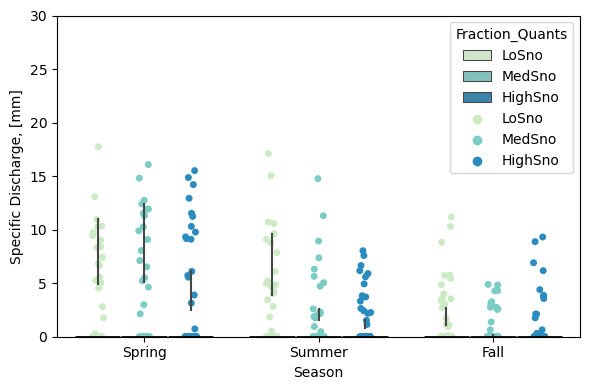

In [ ]:
#Plot total streamflow in each season by snow year type
fig, ax = plt.subplots(1, 1, figsize = (6, 4),  
                       layout = 'tight')

streamSeasonal_frac.Season = pd.Categorical(streamSeasonal_frac.Season, 
                      categories = ["Spring","Summer","Fall"],
                      ordered = True)


sns.boxplot(data = streamSeasonal_frac, x = 'Season', y = 'q.interval', hue = 'Fraction_Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            fliersize = 0,
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = streamSeasonal_frac, x = 'Season', y = 'q.interval', hue = 'Fraction_Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)
ax.set_ylabel('Specific Discharge, [mm]')
ax.set_ylim(0, 30)


plt.savefig('../Figures/HistoricalFigs/streamflow_boxplot_frac.pdf', bbox_inches = 'tight')

(0.0, 30.0)

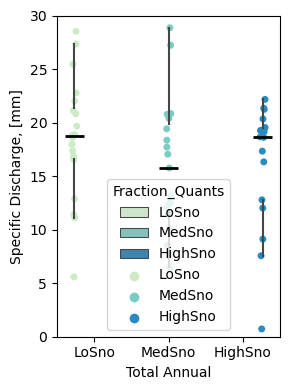

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3, 4),  
                       layout = 'tight')

for_plot = streamSeasonal_frac.groupby(['Year', 'Fraction_Quants'])['q.interval'].sum().reset_index()
for_plot = for_plot[for_plot['q.interval'] > 0]


sns.boxplot(data = for_plot, x = 'Fraction_Quants', y = 'q.interval', hue = 'Fraction_Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            fliersize = 0,
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = for_plot, x = 'Fraction_Quants', y = 'q.interval', hue = 'Fraction_Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)
ax.set_ylabel('Specific Discharge, [mm]')
ax.set_xlabel('Total Annual')
ax.set_ylim(0,30)


## Soil Moisture

In [ ]:
#Merge with snow data
soilMoist_snowfrac = pd.merge(soilMoist_daily, gr_snow_annual[gr_snow_annual.Year > 2007], left_on = 'YEAR', right_on = 'Year', how = 'outer')
soilMoist_snowfrac = soilMoist_snowfrac.drop('Year', axis = 1)
soilMoist_snowfrac.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,S2N_LO_SH,S2N_LO_DP,S2S,S2N,Snowfall_in,Precip_in,Snowfall_SWE_in,Input_Quants,SnowFraction,Fraction_Quants
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,NaN,NaN,0.226308,NaN,48.6,27.92,5.79,LoSno,0.207378,MedSno
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,NaN,NaN,0.225394,NaN,48.6,27.92,5.79,LoSno,0.207378,MedSno
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,0.225000,NaN,48.6,27.92,5.79,LoSno,0.207378,MedSno
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,0.225000,NaN,48.6,27.92,5.79,LoSno,0.207378,MedSno
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,NaN,NaN,0.225312,NaN,48.6,27.92,5.79,LoSno,0.207378,MedSno


In [ ]:
all_water_frac = pd.merge(soilMoist_snowfrac, streamHist_daily[streamHist_daily.Year > 2007], left_on = ['YEAR', 'DOY'], right_on = ['Year', 'DOY'], 
                     how = 'outer')
all_water_frac = all_water_frac.drop('Year', axis = 1)
all_water_frac.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,Precip_in,Snowfall_SWE_in,Input_Quants,SnowFraction,Fraction_Quants,q.interval,Stage.ft,Q.cfs,q.mmh,Month
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,27.92,5.79,LoSno,0.207378,MedSno,0.0,0.0,0.0,0.0,1.0
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,27.92,5.79,LoSno,0.207378,MedSno,0.0,0.0,0.0,0.0,1.0
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,27.92,5.79,LoSno,0.207378,MedSno,0.0,0.0,0.0,0.0,1.0
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,27.92,5.79,LoSno,0.207378,MedSno,0.0,0.0,0.0,0.0,1.0
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,27.92,5.79,LoSno,0.207378,MedSno,0.0,0.0,0.0,0.0,1.0


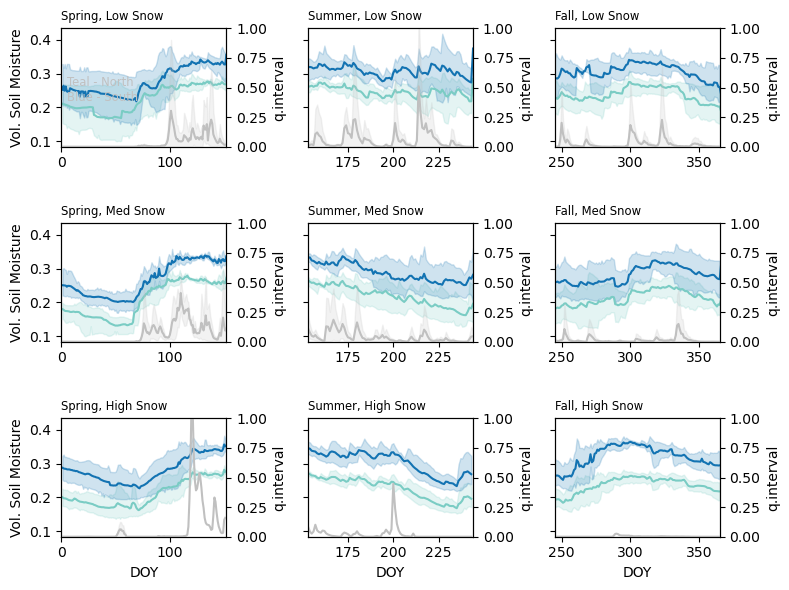

In [ ]:
#Soil moisture and streamflow by snow year and season
def plot_SM_Q_frac(ax_i, ax_j, soilM):
    #find season based on ax column index
    if(ax_i == 0): #spring
        soiltemp = soilM[soilM.MONTH < 6]
        axs[ax_j, ax_i].set_xlim(0, 152)
        axs[ax_j, ax_i].set_ylabel('Vol. Soil Moisture')
    elif(ax_i == 1): #summer
        soiltemp = soilM[(soilM.MONTH > 5) & (soilM.MONTH < 9)]
        axs[ax_j, ax_i].set_xlim(153, 244)
    else: #fall
        soiltemp = soilM[soilM.MONTH > 8]
        axs[ax_j, ax_i].set_xlim(245, 365)

    #find snow year based on ax row index
    if(ax_j == 0): #low snow
        soiltemp_f = soiltemp[soiltemp.Fraction_Quants == 'LoSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    elif(ax_j == 1): #med snow
        soiltemp_f = soiltemp[soiltemp.Fraction_Quants == 'MedSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    else: #high snow
        soiltemp_f = soiltemp[soiltemp.Fraction_Quants == 'HighSno']

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2N', ax = axs[ax_j, ax_i], color = pal[2])
    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2S', ax = axs[ax_j, ax_i], color = pal[4])

    ax2 = axs[ax_j, ax_i].twinx()

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'q.interval', 
                 color = 'silver', zorder = -2, 
                 ax = ax2)
    ax2.set_ylim(0, 1.0)

    season_labels = ['Spring', 'Summer', 'Fall']
    snow_labels = ['Low Snow', 'Med Snow', 'High Snow']

    axs[ax_j, ax_i].set_title(season_labels[ax_i] + ', ' + snow_labels[ax_j], loc = 'left', fontsize = 'small')

fig, axs = plt.subplots(3, 3, figsize = (8, 6), 
    sharey = True, 
    layout = 'tight')

for i in range(0, 3):
    for j in range(0, 3):
        plot_SM_Q_frac(i, j, all_water_frac)

axs[0, 0].text(5, 0.22, 'Teal - North\nBlue - South', color = 'silver', fontsize = 'small')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_Timeseries_frac.pdf')
plt.show()


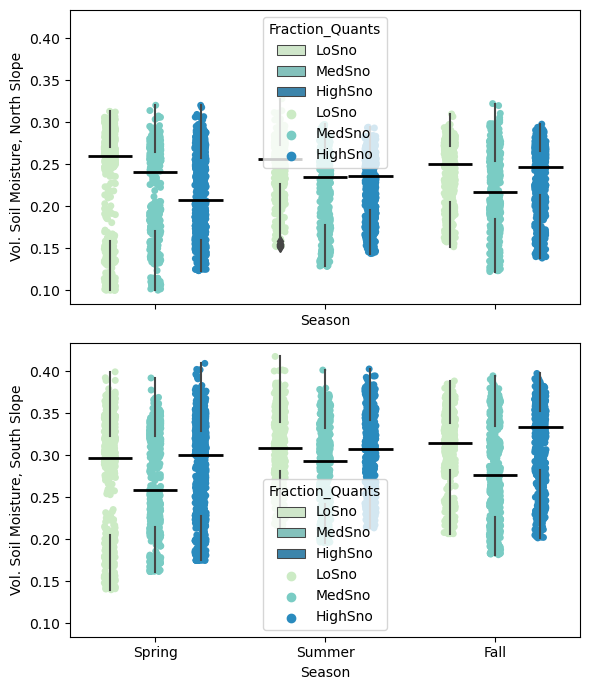

In [ ]:
#Add season column
all_water_frac['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in all_water_frac.MONTH]

fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 7), 
                       sharex = True, 
                       sharey = True, 
                       layout = 'tight')

sns.boxplot(data = all_water_frac, x = 'Season', y = 'S2N', hue = 'Fraction_Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = all_water_frac, x = 'Season', y = 'S2N', hue = 'Fraction_Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)

ax.set_ylabel('Vol. Soil Moisture, North Slope')

sns.boxplot(data = all_water_frac, x = 'Season', y = 'S2S', hue = 'Fraction_Quants',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax2, zorder = 1)
sns.stripplot(data = all_water_frac, x = 'Season', y = 'S2S', hue = 'Fraction_Quants', dodge = True, 
              palette = 'GnBu',
              ax = ax2, zorder = 0)

ax2.set_ylabel('Vol. Soil Moisture, South Slope')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_boxplot_frac.pdf')
plt.show()

# Water Balance Analysis

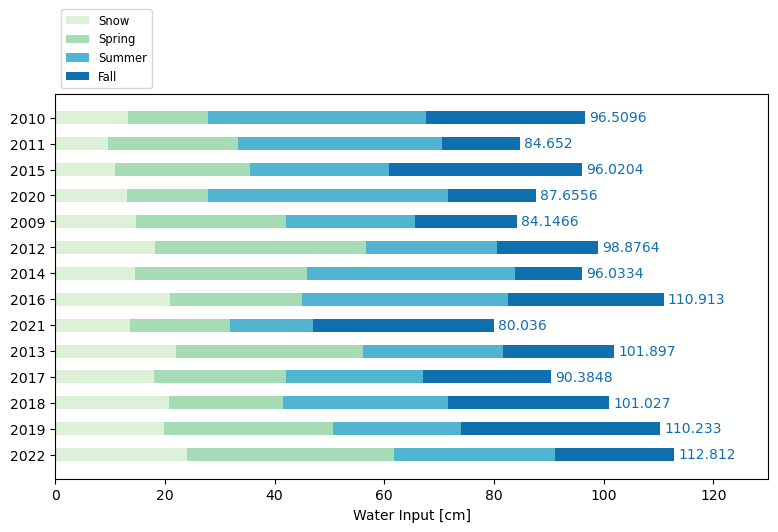

In [ ]:

#Net Water Input Diagram - Hand done kill me now
category_names = ['Snow', 'Spring', 'Summer', 'Fall']

#Snow inputs from binning dataframe, years as defined by fraction_quants
results = {
    #Lo Snow years
    '2010': [13.3096, 14.61, 39.72, 28.87],
    '2011': [9.652, 23.71, 37.24, 14.05],
    '2015': [10.8204, 24.66, 25.41, 35.13],
    '2020': [13.0556, 14.74, 43.85, 16.01], 

    #Med Snow years
    '2009': [14.7066, 27.29, 23.69, 18.46],
    '2012': [18.1864, 38.53, 23.92, 18.24],
    '2014': [14.5034, 31.34, 37.91, 12.28], 
    '2016': [20.8534, 24.21, 37.44, 28.41],
    '2021': [13.716, 18.09, 15.13, 33.1],

    #High Snow years
    '2013': [22.0472, 34.12, 25.43, 20.3],
    '2017': [18.0848, 23.99, 25.06, 23.25],
    '2018': [20.7772, 20.81, 30, 29.44],
    '2019': [19.8628, 30.87, 23.25, 36.25],
    '2022': [23.9522, 37.83, 29.26, 21.77]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['GnBu'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        if(i == 3):
            ax.bar_label(rects, color=color, padding = 3)
    
    ax.legend(bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    ax.set_xlim(0, 130)
    ax.set_xlabel('Water Input [cm]')

    return fig, ax


survey(results, category_names)
plt.savefig('../Figures/HistoricalFigs/NetWaterInput.pdf', bbox_inches = 'tight')
plt.show()

# Two Bin version

In [ ]:
gr_snow_annual['Input_Quants_Duo'] = pd.qcut(gr_snow_annual.Snowfall_in, 2, labels = ['LoSWE', 'HighSWE'])
gr_snow_annual['Fraction_Quants_Duo'] = pd.qcut(gr_snow_annual.SnowFraction, 2, labels = ['LoFrac', 'HighFrac'])
gr_snow_annual.head()

,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,Input_Quants,SnowFraction,Fraction_Quants,Input_Quants_Duo,Fraction_Quants_Duo
0,1962,46.5,25.51,3.54,LoSno,0.138769,LoSno,LoSWE,LoFrac
1,1963,43.6,25.33,4.22,LoSno,0.166601,MedSno,LoSWE,LoFrac
2,1964,48.1,30.39,3.59,LoSno,0.118131,LoSno,LoSWE,LoFrac
3,1965,88.6,32.37,7.90,HighSno,0.244053,HighSno,HighSWE,HighFrac
4,1966,67.7,26.77,8.41,HighSno,0.314158,HighSno,HighSWE,HighFrac


In [ ]:
all_water_merged = pd.merge(all_water_frac, gr_snow_annual[['Year', 'Input_Quants_Duo', 'Fraction_Quants_Duo']], 
                          left_on = 'YEAR', right_on = 'Year')
all_water_merged.columns

Index(['YEAR', 'DOY', 'MONTH', 'S2S_UP_SH', 'S2S_UP_DP', 'S2S_MI_SH',
       'S2S_MI_DP', 'S2S_LO_SH', 'S2S_LO_DP', 'S2N_UP_SH', 'S2N_UP_DP',
       'S2N_MI_SH', 'S2N_MI_DP', 'S2N_LO_SH', 'S2N_LO_DP', 'S2S', 'S2N',
       'Snowfall_in', 'Precip_in', 'Snowfall_SWE_in', 'Input_Quants',
       'SnowFraction', 'Fraction_Quants', 'q.interval', 'Stage.ft', 'Q.cfs',
       'q.mmh', 'Month', 'Season', 'Year', 'Input_Quants_Duo',
       'Fraction_Quants_Duo'],
      dtype='object')

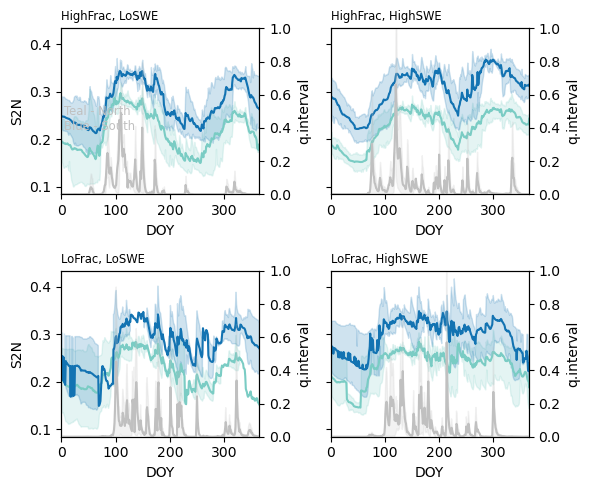

In [ ]:
def plot_SM_trace(ax, temp, label):
    #find season based on ax column index
    sns.lineplot(data = temp, x = 'DOY', y = 'S2N', ax = ax, color = pal[2])
    sns.lineplot(data = temp, x = 'DOY', y = 'S2S', ax = ax, color = pal[4])

    ax2 = ax.twinx()

    sns.lineplot(data = temp, x = 'DOY', y = 'q.interval', 
                 color = 'silver', zorder = -2, 
                 ax = ax2)
    ax2.set_ylim(0, 1.0)
    ax.set_xlim(0, 365)
    ax.set_title(label, fontsize = 'small', loc = 'left')

fig, axs = plt.subplots(2, 2, figsize = (6, 5), 
    sharey = True, 
    layout = 'tight')

ax_array = axs.ravel()
ax_ind = 0
for frac in set(all_water_merged.Fraction_Quants_Duo):
    for swe in set(all_water_merged.Input_Quants_Duo):
        temp = all_water_merged[(all_water_merged.Fraction_Quants_Duo == frac) & (all_water_merged.Input_Quants_Duo == swe)]
        plot_SM_trace(ax_array[ax_ind], temp, frac + ', ' + swe)
        ax_ind = ax_ind + 1

axs[0, 0].text(5, 0.22, 'Teal - North\nBlue - South', color = 'silver', fontsize = 'small')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_Timeseries_fracandsnow.pdf')
plt.show()
